# Overwatch Data Visualization

Before running any statistical analysis on data, it is usually a good idea to visualize the dataset. This helps us get a general sense of data patterns, which can help generate hypotheses that can then be tested with more formal statistical models.

My own personal philosophy about data visualization/exploration is to approach it with targetted questions of interest. It is all too easy to fall down the rabbit hole of plotting absolutely everything, without a sense of what the end goal is.

Rather than an in-depth exploration of the data, this post serves more as a Python (matplotlib) tutorial demonstrating how to create different types of plots in service of answering specific research questions. The overarching goal is to better understand how I perform in the game. I'll be cleaning and wrangling data as I go to make it more interpretable and easier to visualize.

## Imports

In [232]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load data

In [48]:
df = pd.read_csv('../data/all_seasons.csv')
df.tail(10)

,season,Game #,Start SR,End SR,SR Change,Team SR avg,Enemy SR avg,Team Stack,Enemy Stack,Role 1,...,Obj_time_career,Obj_time_medal,Dmg,Dmg_career,Dmg_medal,Heal,Heal_career,Heal_medal,Death,Death_career
473,9,305,2435,2453,18.0,2386,2402,2.0,2.0,Tank,...,01:35,Gold,8117.0,4916.0,None,0.0,6067.0,None,13.0,7.26
474,9,306,2453,2480,27.0,2545,2538,2.0,2.0,Support,...,01:35,Gold,5045.0,4916.0,None,6426.0,6067.0,Silver,4.0,7.25
475,9,307,2480,2503,23.0,P,P,2.0,2.0,Tank,...,01:35,Bronze,6011.0,4920.0,None,0.0,6048.0,None,9.0,7.25
476,9,308,2503,2482,-21.0,2479,2477,1.0,1.0,Tank,...,01:35,Gold,8421.0,4926.0,Bronze,0.0,6028.0,None,12.0,7.26
477,9,309,2482,2456,-26.0,2447,2457,2.0,2.0,Support,...,01:35,Bronze,3378.0,4915.0,None,9435.0,6029.0,Silver,19.0,7.28
478,9,310,2456,2480,24.0,2476,2481,2.0,2.0,Support,...,01:35,Silver,1770.0,5366.0,None,8639.0,8466.0,Silver,3.0,6.57
479,9,311,2480,2457,-23.0,2477,2484,2.0,3.0,Tank,...,01:36,Bronze,9571.0,4911.0,None,300.0,6010.0,None,11.0,7.27
480,9,312,2457,2480,23.0,2465,2466,2.0,2.0,Support,...,01:36,None,9473.0,4914.0,None,14859.0,6023.0,Silver,9.0,7.26
481,9,313,2480,2456,-24.0,2471,2471,2.0,1.0,Support,...,01:36,None,2369.0,4914.0,None,3280.0,6024.0,Silver,4.0,7.26
482,9,314,2456,2428,-28.0,2469,2449,3.0,4.0,Tank,...,01:36,Silver,2335.0,4909.0,None,0.0,6010.0,None,8.0,7.27


## Are there improvements over time?

To identify whether there is improvement over time, we can simply plot skill rating over time for each season. We can either use a `groupby` and create a plot for each season, or plot all seasons on the same graph. `Pandas` offers some plotting tools (`df.groupby('season').plot('Game #', 'End SR')`), but I generally find I have much more control when using `matplotlib` directly

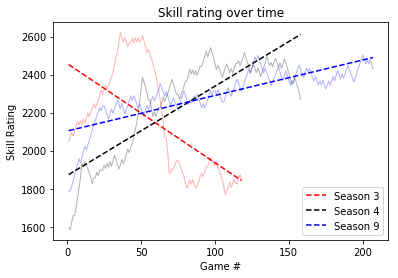

In [258]:
# Reset game number for season 9. It would be faster to use range() to create the new Game numbers, but there might be instances where games were skipped/not recorded
df.update(df.loc[df['season']==9, 'Game #'] - df.loc[df['season']==9, 'Game #'].min() + 1)

# Plot
colours = ['r', 'k', 'b']

fig, ax = plt.subplots(nrows=1, ncols=1)
for s, c in zip(df['season'].unique(), colours):
    x = df[df['season'] == s]['Game #']
    y = df[df['season'] == s]['End SR']
    
    ax.plot(x, y, color=c, alpha=0.3, linewidth=1, label='')
    
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color=c, label='Season {}'.format(s), linestyle='--')

ax.set_xlabel('Game #')
ax.set_ylabel('Skill Rating')
plt.title('Skill rating over time')
plt.legend()
plt.show()

A linear fit is likely not the most appropriate here, but it's good enough for approximating a crude trend. Clearly I went on a crazy losing streak in Season 3, but Seasons 4 and 9 generally show improvement over time. It makes sense that improvement in Season 9 was not as rapid as Season 4, as I had just returned to the game after a long break and trying to find my footing again (new characters, maps etc.)

## Which role do I perform the best on?

I mostly fill when playing ranked, and that usually means I end up playing support or tank. So first, we should see how many times I played of each role, and then look at win percentage per role

*Note:* role data was only available in Season 9

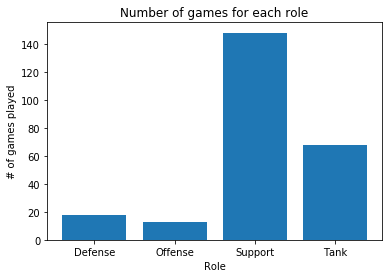

In [256]:
# get roles counts, even if there were multiple per game
role1_counts = df[df['season'] == 9]['Role 1'].value_counts()
role2_counts = df[df['season'] == 9]['Role 2'].value_counts()

role_counts = role1_counts + role2_counts

plt.bar(role_counts.index, role_counts)
plt.xlabel('Role')
plt.ylabel('# of games played')
plt.title('Number of games for each role')
plt.show()

Result       Draw      Loss       Win
Role                                 
Defense  0.000000  0.444444  0.555556
Offense  0.076923  0.615385  0.307692
Support  0.020270  0.439189  0.540541
Tank     0.029412  0.485294  0.485294


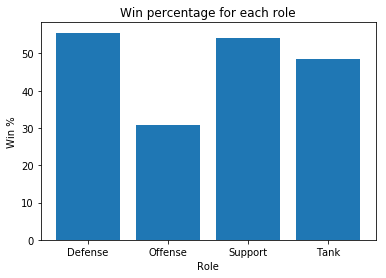

In [257]:
r1 = df[df['Role 1'].notnull()][['Role 1', 'Result']].rename(columns={'Role 1': 'Role'})
r2 = df[df['Role 2'].notnull()][['Role 2', 'Result']].rename(columns={'Role 2': 'Role'})
win_loss = r1.append(r2)

xtab = pd.crosstab(win_loss['Role'], win_loss['Result']).apply(lambda r: r/r.sum(), axis=1)
print(xtab)

plt.bar(xtab.index, xtab['Win']*100)
plt.xlabel('Role')
plt.ylabel('Win %')
plt.title('Win percentage for each role')
plt.show()

Suspicion confirmed: filling means playing support or tank. My highest win rate comes from playing the Defense role (mostly Junkrat), although the win % is biased due to the low number of total games played in that role. This is followed closely by playing Support, and the win % is likely to be more stable due to the large number of games (owing to my new-found obsession with playing Moira).

## Which game mode takes the longest to complete?

Do certain game modes take longer than others? And which specific map, within each game mode, takes the longest? To answer this, we first need to take the `Match Time` variable (which was only available for Season 9) and convert it minutes for easier plotting

                match_mins
Mode                      
Assault          12.369281
Assault/Escort   14.124479
Control          10.847778
Escort           12.501111


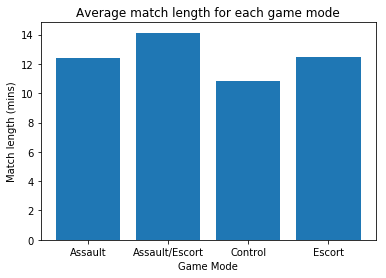

In [253]:
df['match_time_split'] = df['Match Time'].str.split(':')
df['match_mins'] = df[df['match_time_split'].notnull()]['match_time_split'].str[0].astype(float) + (df[df['match_time_split'].notnull()]['match_time_split'].str[1].astype(float)/60)

mode_time = df[['Map', 'Mode', 'match_mins']].groupby('Mode').mean()
print(mode_time)

plt.bar(mode_time.index, mode_time['match_mins'])
plt.title('Average match length for each game mode')
plt.xlabel('Game Mode')
plt.ylabel('Match length (mins)')
plt.show()

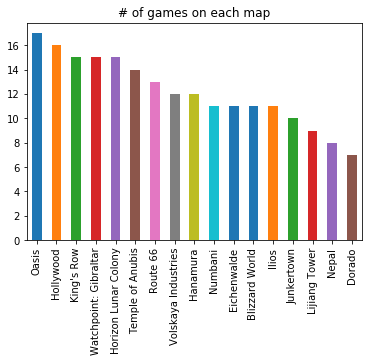

In [252]:
df['Map'].value_counts().plot(kind='bar', title='# of games on each map')

There is generally a pretty good distribution of maps, although some of the maps (e.g. Dorado, Nepal) didn't come up very often. I would have thought there'd be a more uniform distribution of maps - this is a good candidate for a Chi-square test to check the likelihood of getting a distribution like this, but I'll save that for another post

                      Map            Mode  match_mins color
0                   Nepal         Control   10.077083     r
1           Lijiang Tower         Control   10.118519     r
2                   Oasis         Control   11.222549     r
3                   Ilios         Control   11.425758     r
4   Watchpoint: Gibraltar          Escort   11.572222     g
5                Hanamura         Assault   11.756944     b
6     Volskaya Industries         Assault   12.063889     b
7        Temple of Anubis         Assault   12.689744     b
8              Junkertown          Escort   12.795000     g
9                Route 66          Escort   12.835897     g
10   Horizon Lunar Colony         Assault   12.858333     b
11         Blizzard World  Assault/Escort   13.278788     k
12            Eichenwalde  Assault/Escort   13.366667     k
13                 Dorado          Escort   13.450000     g
14              Hollywood  Assault/Escort   14.361458     k
15                Numbani  Assault/Escor

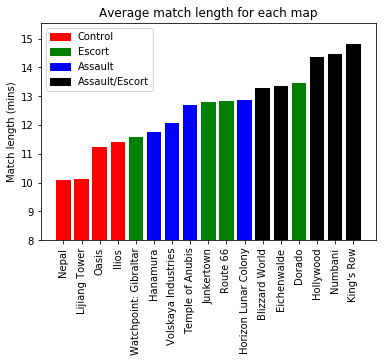

In [254]:
map_time = df[['Map', 'Mode', 'match_mins']].groupby(['Map','Mode']).mean().reset_index()
map_time = map_time.sort_values('match_mins').reset_index(drop=True)
map_time['color'] = map_time['Mode'].replace({'Control': 'r',
                                              'Escort': 'g',
                                              'Assault': 'b',
                                              'Assault/Escort': 'k'})
print(map_time)

ind = range(len(map_time['Map'].unique()))

plt.bar(ind, map_time['match_mins'], color=map_time['color'])

c = mpatches.Patch(color='r', label='Control')
e = mpatches.Patch(color='g', label='Escort')
a = mpatches.Patch(color='b', label='Assault')
ae = mpatches.Patch(color='k', label='Assault/Escort')

plt.legend(handles=[c,e,a,ae], loc=2)
plt.xticks(ind, map_time['Map'], rotation='vertical')
plt.ylim(8,)
plt.ylabel('Match length (mins)')
plt.title('Average match length for each map')

plt.show()

There is quite a range in game times across the different maps, with Control maps (e.g. Nepal, Lijiang Tower) generally finishing faster than Assault/Escort maps (e.g. King's Row, Numbani). Within each game mode, Escort maps seem to have the largest variability, with Watchpoint: Gilbraltar having a game time (almost) as short as some Control maps, and Dorado taking longer than some of the Assault/Escort maps.

## Which game mode has a higher win percentage?

Result              Draw      Loss       Win
Mode                                        
Assault         0.037736  0.358491  0.603774
Assault/Escort  0.031250  0.453125  0.515625
Control         0.000000  0.466667  0.533333
Escort          0.000000  0.511111  0.488889


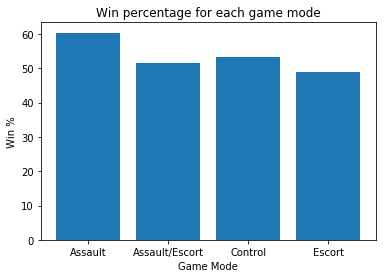

In [269]:
xtab = pd.crosstab(df['Mode'], df['Result']).apply(lambda r: r/r.sum(), axis=1)
print(xtab)

plt.bar(xtab.index, xtab['Win']*100)
plt.xlabel('Game Mode')
plt.ylabel('Win %')
plt.title('Win percentage for each game mode')
plt.show()

Most game modes have around 50% win rate (as expected), but Assault maps (e.g. Hanamura) have a slightly higher win percentage at over 60%


## Does SR gain correlate with the SR difference between my team and the enemy team?


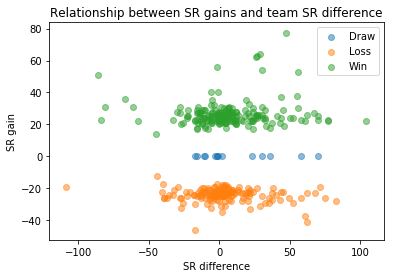

In [382]:
df['SR diff'] = df['Team SR avg'].replace({'P': np.nan}).astype(float) - df['Enemy SR avg'].replace({'P': np.nan}).astype(float)

fig, ax = plt.subplots()

groups = df.groupby('Result')

for name, group in groups:
    ax.scatter(group['SR diff'], group['SR Change'], label=name, alpha=0.5)

plt.xlabel('SR difference')
plt.ylabel('SR gain')
plt.title('Relationship between SR gains and team SR difference')
plt.legend()
plt.show()